<a href="https://colab.research.google.com/github/AUT-Student/NLP-HW3/blob/main/NLP_HW3_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.models.word2vec import Word2Vec
import gensim.downloader as gensim_api

import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import LSTM, Dense, Input, Embedding, Bidirectional, TimeDistributed
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import backend as K

# Dataset

In [2]:
!gdown 11WeeMttH6I6MJ0t1h7FVSEtw0lKwpRA6
!gdown 1gLGNxjQzy6C8y4Oivr8etU1MMGfuKuEE
!gdown 127-sOeW6KMf6XNSAVM3bGjfwnmW0NciU

Downloading...
From: https://drive.google.com/uc?id=11WeeMttH6I6MJ0t1h7FVSEtw0lKwpRA6
To: /content/dev.conll
100% 478k/478k [00:00<00:00, 114MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gLGNxjQzy6C8y4Oivr8etU1MMGfuKuEE
To: /content/test.conll
100% 677k/677k [00:00<00:00, 155MB/s]
Downloading...
From: https://drive.google.com/uc?id=127-sOeW6KMf6XNSAVM3bGjfwnmW0NciU
To: /content/train.conll
100% 11.4M/11.4M [00:00<00:00, 185MB/s]


In [3]:
def dependency_create(row):
  dependency_index = row["DependencyIndex"]
  index = row["Index"]

  if dependency_index == 0:
    return "Root"
  else:
    different = dependency_index - index

    if different > 0:
      return f"{different}R"
    elif different < 0:
      return f"{abs(different)}L"
    else:
      raise Exception(row)

In [4]:
def load_and_preprocess_dataset(path):
  dataset = pd.read_csv(path, delimiter="\t", header=None, names=["Index", "Word", "DependencyIndex"])
  dataset = dataset.dropna()
  dataset["Index"] = dataset["Index"].astype(int)
  dataset["DependencyIndex"] = dataset["DependencyIndex"].astype(int)
  dataset["Dependency"] = dataset.apply(dependency_create, axis=1)

  return dataset

In [5]:
train_dataset = load_and_preprocess_dataset("/content/train.conll")
valid_dataset = load_and_preprocess_dataset("/content/dev.conll")
test_dataset = load_and_preprocess_dataset("/content/test.conll")

In [6]:
label_dictionary = {"PAD": 0}

for i, label in enumerate(set(train_dataset["Dependency"].values.tolist() +
                              valid_dataset["Dependency"].values.tolist() +
                              test_dataset["Dependency"].values.tolist())):
  label_dictionary[label] = i+1

In [7]:
len(label_dictionary)

159

In [8]:
max(max(train_dataset["Index"].values), max(valid_dataset["Index"].values), max(test_dataset["Index"].values))

141

In [9]:
def convert_to_sequence(dataset):
  sequenced_dataset = []

  for i, item in dataset.iterrows():
    if item["Index"] == 1:
      if i>0:
        sequenced_dataset.append({"Words": new_words, "Labels": new_labels})
      new_words = [item["Word"]]
      new_labels = [item["Dependency"]]
    else:
      new_words.append(item["Word"])
      new_labels.append(item["Dependency"])
  
  sequenced_dataset.append({"Words": new_words, "Labels": new_labels})
  return pd.DataFrame(sequenced_dataset)

In [10]:
train_dataset = convert_to_sequence(train_dataset)
valid_dataset = convert_to_sequence(valid_dataset)
test_dataset = convert_to_sequence(test_dataset)

# Word2Vec

In [11]:
print(gensim_api.load("word2vec-google-news-300", return_path=True))

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [12]:
word2vec_model = gensim_api.load("word2vec-google-news-300")

In [13]:
def apply_embedding(row):
  vectors = []
  for word in row["Words"]:
    try:
      vector = word2vec_model.get_vector(word)
    except KeyError:
      vector = np.zeros(300)
    vectors.append(vector)

  for i in range(141-len(row["Words"])):
    vectors.append(np.zeros(300))

  return np.stack(vectors)

In [14]:
def apply_label_index(row):
  labels = []
  for label in row["Labels"]:
    labels.append(label_dictionary[label])

  for i in range(141-len(row["Labels"])):
    labels.append(label_dictionary["PAD"])
  
  return np.stack(labels)

In [15]:
class TrainDatasetGenerator(keras.utils.Sequence):
  def __init__(self, train_dataset, batch_size):
    self.train_dataset = train_dataset
    self.batch_size = batch_size

  def __len__(self):
    return int(len(self.train_dataset)/self.batch_size)
  
  def __getitem__(self, idx):
    batch_vectors = np.stack(train_dataset.iloc[idx * self.batch_size : (idx+1) * self.batch_size].apply(apply_embedding, axis=1).values)
    batch_labelindex = np.stack(train_dataset.iloc[idx * self.batch_size : (idx+1) * self.batch_size].apply(apply_label_index, axis=1).values)

    return batch_vectors, batch_labelindex

In [16]:
valid_dataset["Vector"] = valid_dataset.apply(apply_embedding, axis=1)
valid_dataset["LabelIndex"] = valid_dataset.apply(apply_label_index, axis=1)
test_dataset["Vector"] = test_dataset.apply(apply_embedding, axis=1)
test_dataset["LabelIndex"] = test_dataset.apply(apply_label_index, axis=1)

# BiLSTM Model

In [17]:
class BiLSTM(keras.Model):
  def __init__(self):
    super().__init__()
    self.model = Sequential([
                             Input((141, 300)),
                             Bidirectional(LSTM(32, return_sequences=True)),
                             TimeDistributed(Dense(159, activation="softmax"))
    ])
  
  def call(self, inputs):
    return self.model(inputs)

In [18]:
def ignore_class_accuracy(to_ignore=0):
   # Refrence: https://nlpforhackers.io/lstm-pos-tagger-keras/
  
  def ignore_accuracy(y_true, y_pred):
    y_pred_class = K.argmax(y_pred, axis=-1)
    y_true_class = K.argmax(y_true, axis=-1)
    y_true_class = K.cast(y_true, "int64")

    ignore_mask = K.cast(K.not_equal(y_pred_class, to_ignore), 'int32')
    matches = K.cast(K.equal(y_true_class, y_pred_class), 'int32') * ignore_mask
    accuracy = K.sum(matches) / K.maximum(K.sum(ignore_mask), 1)
    return accuracy
  
  return ignore_accuracy

In [19]:
bilstm_model = BiLSTM()

In [20]:
bilstm_model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["Accuracy", ignore_class_accuracy(0)])

In [21]:
es_callback = EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

In [22]:
train_dataset_generator = TrainDatasetGenerator(train_dataset=train_dataset, batch_size=32)

In [ ]:
history = bilstm_model.fit(x=train_dataset_generator,
                           epochs=20,
                           validation_data=(np.stack(valid_dataset["Vector"].values),
                                            np.stack(valid_dataset["LabelIndex"].values)))

Epoch 1/20
1244/1244 [==============================] - 51s 36ms/step - loss: 0.5224 - Accuracy: 0.8899 - ignore_accuracy: 0.3825 - val_loss: 0.3134 - val_Accuracy: 0.9146 - val_ignore_accuracy: 0.5141
Epoch 2/20
1244/1244 [==============================] - 45s 36ms/step - loss: 0.2709 - Accuracy: 0.9284 - ignore_accuracy: 0.6006 - val_loss: 0.2471 - val_Accuracy: 0.9348 - val_ignore_accuracy: 0.6320
Epoch 3/20
1244/1244 [==============================] - 46s 37ms/step - loss: 0.2238 - Accuracy: 0.9411 - ignore_accuracy: 0.6692 - val_loss: 0.2148 - val_Accuracy: 0.9424 - val_ignore_accuracy: 0.6686
Epoch 4/20
1244/1244 [==============================] - 44s 36ms/step - loss: 0.1991 - Accuracy: 0.9468 - ignore_accuracy: 0.6963 - val_loss: 0.1973 - val_Accuracy: 0.9468 - val_ignore_accuracy: 0.6892
Epoch 5/20
1244/1244 [==============================] - 45s 36ms/step - loss: 0.1843 - Accuracy: 0.9500 - ignore_accuracy: 0.7119 - val_loss: 0.1859 - val_Accuracy: 0.9494 - val_ignore_accurac

# Evaluation

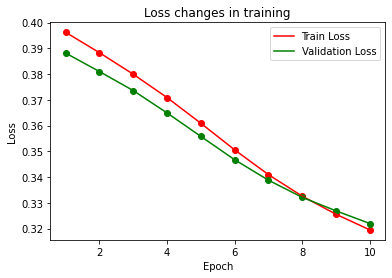

In [ ]:
train_loss = history.history["loss"]
valid_loss = history.history["val_loss"]

plt.scatter(range(1, len(train_loss)+1), train_loss, color="red")
plt.scatter(range(1, len(train_loss)+1), valid_loss, color="green")

plt.plot(range(1, len(train_loss)+1), train_loss, color="red", label="Train Loss")
plt.plot(range(1, len(train_loss)+1), valid_loss, color="green", label="Validation Loss")

plt.legend()
plt.title("Loss changes in training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()